In [65]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

seed = 42
num_pool = 200 # as random pool for bases of biclusters
# num_upper_bound = 20 # upper bound of number of biclusters
# num_bicluster = np.random.RandomState(seed+1).randint(1, num_upper_bound, 1)[0] # number of biclusters
num_bicluster = 15

## psedo random vector with fixed seed, ori(0), ori(1), ... ori(num_bicluster-1)
ori = np.random.RandomState(seed).rand(num_bicluster, num_pool)

# random n(0) n(1) n(2) ... n(num_bicluster-1) as the length of each bicluster base vector
n = np.random.RandomState(seed).randint(num_pool/5, num_pool, num_bicluster)
m = np.random.RandomState(seed+1).randint(num_pool/5, num_pool, num_bicluster) # m is the height of biclusters
# scale = np.random.RandomState(seed+2).rand(num_bicluster) 

# p is a list, p[i] is a n[i]-length vector, as the base of bicluster i
p = []
for i in range(num_bicluster):
    p.append(ori[i][:n[i]])

for i in range(num_bicluster):
    assert len(p[i]) == n[i]

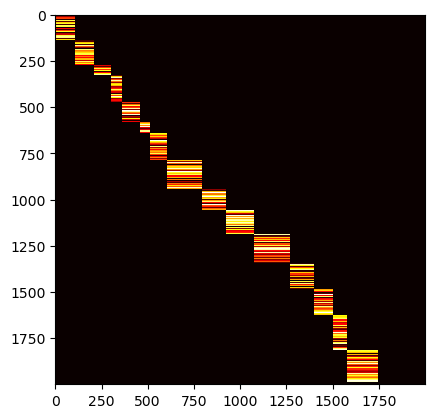

In [66]:
# new a M x N matrix (zeros)
M = 2000
N = 2000

A = np.zeros((M, N))

# A(0:n(0), 0:m(0)) = p(0)
# A(n(0):n(0)+n(1), 0:m(1)) = p(1)
# ...

startx = starty = 0

for i in range(num_bicluster):
    for j in range(m[i]):
        A[startx:startx+n[i], starty+j] = p[i]
    startx += n[i]
    starty += m[i]

# show A as a heatmap
plt.imshow(A, cmap='hot', interpolation='nearest')
plt.show()




In [67]:
n[13]

191